In [557]:
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install chaospy
!{sys.executable} -m pip install sklearn
from sklearn.metrics import mean_squared_error
import numpy
import chaospy as ch
from matplotlib import pyplot

In [558]:
class liftCompV(): 
    def __init__(self,Cl,A,rho):
        self.CL = Cl
        self.A = A
        self.rho = rho
    def compute(self,v):
        return (.5 * self.CL * self.A * self.rho * v**2)

In [567]:
distr = ch.Normal(2,.3)
samples = distr.sample(1e5)
print(samples)
lift = liftCompRho(.3,1,1)
#lift = liftCompV(.3,1,1)

[2.10968463 2.42777808 1.69741266 ... 1.65171797 2.00217143 2.21383517]


In [568]:
obs = [lift.compute(i) for i in samples]
print(obs[0:10])

[0.3164526942967913, 0.3641667117473206, 0.25461189892281477, 0.32758444355665367, 0.3608026120614128, 0.24461171647423774, 0.35348143878965604, 0.2433942293476354, 0.25950724738440795, 0.30339123400548357]


E 0.30001156416490043
sd 0.04512287502118207


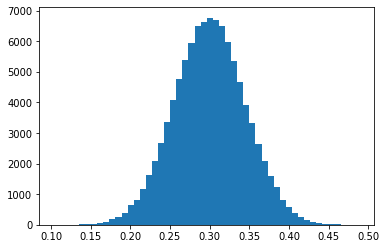

In [569]:
pyplot.hist(obs,bins=50)
E = numpy.mean(obs)
std = numpy.std(obs)
print("E " + str(E))
print("sd "+ str(std))

In [570]:
class quadrature():
    def __init__(self,distr):
        self.distr = distr 
    def makeQuadrature(self,order, rule="undefined", growth=False):
        self.rule = rule
        self.order = order
        self.growth =growth
        if isinstance(order, list):
            self.quadrature = [ch.generate_quadrature(ord, self.distr, rule=rule,growth= growth) for ord in order]
        else:
            self.quadrature = ch.generate_quadrature(order, self.distr, rule=rule,growth= growth)
    def plot(self):
        pyplot.subplot()
        pyplot.title(self.rule + " Growth " + str(self.growth))
        if len(self.order)>1:
            p= [pyplot.scatter(quad[0],[ordi] *quad[0].size,s=quad[1]*1e3) for ordi,quad in zip(self.order, self.quadrature)]
        else:
            p = pyplot.scatter(self.quadrature[0],[self.order]*self.quadrature[0].size,s=self.quadrature[1]*1e3)
        return p
    def observe(self, model):
        obs = []
        for nodes in self.quadrature:
            obs.append([model(node) for node in nodes[0]])
            self.observations = obs
        return obs

In [571]:
distrProxy = distr
#distrProxy = ch.Normal(E-std*.3,E*std*.3)
#distrProxy = ch.Uniform(100-.3*3,100+.3*3)
print(distrProxy)

Normal(mu=2, sigma=0.3)


In [572]:
quadGauss = quadrature(distrProxy)
quadClenGrowth = quadrature(distrProxy)
quadGaussGrowth = quadrature(distrProxy)
quadClen = quadrature(distrProxy)

In [607]:
quadGauss.makeQuadrature([1,2,3,4], rule = "G")
quadGaussGrowth.makeQuadrature([1,2,3,4], rule = "G",growth=True)
quadClen.makeQuadrature([1,2,3,4],rule = "clenshaw_curtis",growth=False)
quadClenGrowth.makeQuadrature([1,2,3,4],rule = "clenshaw_curtis",growth=True)

In [608]:
quadGauss.quadrature[0]

(array([[1.7, 2.3]]), array([0.5, 0.5]))

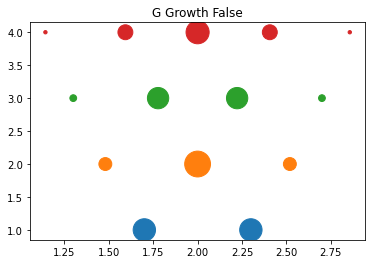

In [609]:
quadGauss.plot()

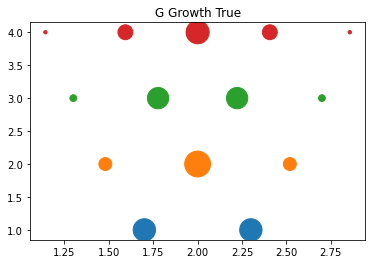

In [610]:
quadGaussGrowth.plot()

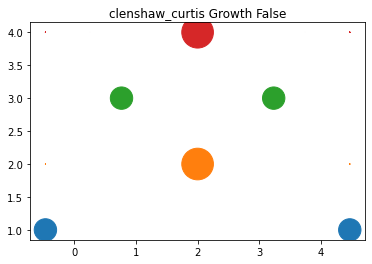

In [611]:
quadClen.plot()

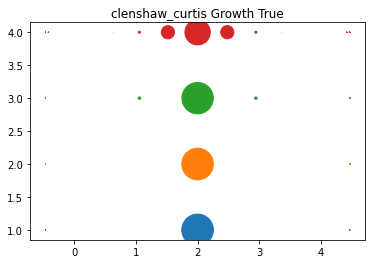

In [612]:
quadClenGrowth.plot()

In [600]:
expansion = [ch.generate_expansion(order, distrProxy)for order in range(1, 5)]
expansion

[polynomial([1.0, q0-2.0]),
 polynomial([1.0, q0-2.0, q0**2-4.0*q0+3.91]),
 polynomial([1.0, q0-2.0, q0**2-4.0*q0+3.91, q0**3-6.0*q0**2+11.73*q0-7.46]),
 polynomial([1.0, q0-2.0, q0**2-4.0*q0+3.91, q0**3-6.0*q0**2+11.73*q0-7.46,
             q0**4-8.0*q0**3+23.46*q0**2-29.840000000000003*q0+13.8643])]

In [493]:
quadGauss.observe(lift.compute)
quadClen.observe(lift.compute)

[[array([0.3223734, 1.8019734])],
 [array([0.3223734, 0.15     , 1.8019734])],
 [array([0.3223734 , 0.00814335, 0.74794335, 1.8019734 ])],
 [array([0.3223734, 0.0829691, 0.15     , 1.1292043, 1.8019734])]]

In [500]:
mod= [ch.fit_quadrature(expansion[ind],quadGauss.quadrature[ind][0] , quadGauss.quadrature[ind][1], quadGauss.observations[ind][0]) for ind in range(0, 4)]
[print(str(m.round(3)) + "\n Exp "+ str(ch.E(m, distrProxy)-E) + " STD "+ str(ch.Std(m, distrProxy)-std) ) for m in mod]

0.3*q0-0.136
 Exp 0.00018378848807612536 STD -0.002402888515611837
0.15*q0**2
 Exp 0.0001837884880761531 STD -0.00040017116443784306
0.15*q0**2
 Exp 0.00018378848807612536 STD -0.00040017116443785694
0.15*q0**2
 Exp 0.00018378848807618087 STD -0.0004001711644378847


[None, None, None, None]

In [501]:
mod2= [ch.fit_quadrature(expansion[ind],quadClen.quadrature[ind][0] , quadClen.quadrature[ind][1], quadClen.observations[ind][0]) for ind in range(0, 4)]
[print(str(m.round(3)) + "\n Exp "+ str(ch.E(m, distrProxy)-E) + " STD "+ str(ch.Std(m, distrProxy)-std) ) for m in mod2]

0.3*q0+0.762
 Exp 0.8988571884880764 STD -0.002402888515611837
-1.667*q0**2+3.633*q0-1.667
 Exp -0.013316211511923276 STD 0.13803148391943587
0.24*q0**3-0.456*q0**2+0.426*q0+0.143
 Exp 0.21472713848892247 STD 0.004980766453815552
6.136*q0**4-24.436*q0**3+31.512*q0**2-13.989*q0+1.226
 Exp -0.013316183467887072 STD 0.2429080367784231


[None, None, None, None]

In [502]:
pc_model_approx =[ch.fit_regression(expansion[ind],quadGauss.quadrature[ind][0] , quadGauss.observations[ind][0]) for ind in range(0, 4)]
[print(str(m.round(3)) + "\n Exp "+ str(ch.E(m, distrProxy)-E) + " STD "+ str(ch.Std(m, distrProxy)-std) ) for m in pc_model_approx]

0.3*q0-0.137
 Exp 0.0001837884880760976 STD -0.002402888515611837
0.15*q0**2
 Exp 0.0001837884880760976 STD -0.00040017116443796796
0.15*q0**2
 Exp 0.00018378848807587556 STD -0.00040017116443796796
0.15*q0**2
 Exp 0.0001837884880761531 STD -0.00040017116443805123


[None, None, None, None]

In [503]:
pc_model_approx =[ch.fit_regression(expansion[ind],quadClen.quadrature[ind][0] , quadClen.observations[ind][0]) for ind in range(0, 4)]
[print(str(m.round(3)) + "\n Exp "+ str(ch.E(m, distrProxy)-E) + " STD "+ str(ch.Std(m, distrProxy)-std) ) for m in pc_model_approx]

0.3*q0+0.762
 Exp 0.8988571884880762 STD -0.0024028885156117535
0.15*q0**2
 Exp 0.0001837884880758478 STD -0.0004001711644380235
0.15*q0**2
 Exp 0.0001837884880760421 STD -0.00040017116443803735
0.15*q0**2
 Exp 0.00018378848807637516 STD -0.0004001711644380235


[None, None, None, None]

In [512]:
sobol_nodes = [ch.sobol_samples[:, i] for i in range(3,8)]

AttributeError: module 'chaospy' has no attribute 'sobol_samples'

In [552]:
sobol_samples = [ch.create_sobol_samples(i,1)*1.35 for i in range(1,8)]

In [553]:
sobol_obs = [lift.compute(i) for s in sobol_samples for i in s]
sobol_obs

[array([0.06834375]),
 array([0.06834375, 0.15377344]),
 array([0.06834375, 0.15377344, 0.01708594]),
 array([0.06834375, 0.15377344, 0.01708594, 0.03844336]),
 array([0.06834375, 0.15377344, 0.01708594, 0.03844336, 0.20930273]),
 array([0.06834375, 0.15377344, 0.01708594, 0.03844336, 0.20930273,
        0.10678711]),
 array([0.06834375, 0.15377344, 0.01708594, 0.03844336, 0.20930273,
        0.10678711, 0.00427148])]

In [554]:
expansion = [ch.generate_expansion(order, distrProxy)for order in range(1, 9)]
sobol_mod =[ch.fit_regression(exp,samp , obs) for exp,samp , obs in zip(expansion,sobol_samples , sobol_obs)]
[print(str(m.round(3)) + "\n Exp "+ str(ch.E(m, distrProxy)-E) + " STD "+ str(ch.Std(m, distrProxy)-std) ) for m in sobol_mod]

-0.02*q0+0.082
 Exp -0.10150162700090065 STD -0.08637596652578713
-0.083*q0**2+0.394*q0-0.159
 Exp -0.019865010186323168 STD -0.023454352031838488
-0.138*q0**3+0.43*q0**2-0.173*q0+0.032
 Exp -0.011592995130938782 STD -0.02142924528828942
-0.07*q0**4+0.178*q0**3-0.01*q0**2+0.061*q0-0.008
 Exp -0.005773267079348082 STD -0.012090886371980206
-0.035*q0**5+0.129*q0**4-0.183*q0**3+0.273*q0**2-0.04*q0+0.005
 Exp -0.0008275200366255342 STD -0.0031003380518445783
-0.017*q0**6+0.079*q0**5-0.146*q0**4+0.139*q0**3+0.078*q0**2+0.019*q0-0.002
 Exp -0.00023115405208629092 STD -0.0016063923564431093
-0.006*q0**7+0.03*q0**6-0.059*q0**5+0.061*q0**4-0.035*q0**3+0.162*q0**2-0.002*q0
 Exp -5.017978028543091e-05 STD -0.0011333244999523623


[None, None, None, None, None, None, None]

In [555]:
sobolMC = [sob_mod(samples) for sob_mod in sobol_mod ]

In [556]:
[print("Exp "+ str(numpy.mean(m)- E) + " STD "+ str(numpy.std(m)-std) ) for m in sobolMC]

Exp -0.10148058517577535 STD -0.08634695879162878
Exp -0.020175295193572362 STD -0.023088821504203272
Exp -0.011836567546546495 STD -0.021176097296037186
Exp -0.005998644364946737 STD -0.011796510859182041
Exp -0.0010248869630519186 STD -0.0027294138257708406
Exp -0.00042015402627040843 STD -0.0012164986218460572
Exp -0.00023694188273823413 STD -0.0007356342774588742


[None, None, None, None, None, None, None]